# Video Feature Analysis SIM 1 - Detecting Kermit and Waldorf & Statler
**Authors: Sakka Mahmoud Abdussalem, Kravchenko Oleksandra**

This notebook contains the video feature analysis for the Similarity Modeling 1 project. The objective is to detect the presence of Kermit or Waldorf and Statler in a scene using video features.

**Note**: this notebook includes video that visualise features applied on the Muppet show episodes directly. To activate those videos, change `show_video` to `True`. The kernel will probably crash if you want to exit the video, so you'd have to restart the notebook. They are not that important but nevertheless interesting to see the methods working directly frame-by-frame. 

## Timesheets
**Oleksandra's timesheet**

<table>
<thead>
  <tr>
    <th>Date</th>
    <th>Task</th>
    <th>Hours</th>

  </tr>
</thead>
<tbody>
  <tr>
    <td>07.01.25</td>
    <td>Set up this notebook and research video features to try</td>
    <td>2 hrs</td>
  </tr>

  <tr>
    <td>07.01.25</td>
    <td>Testing video features: contours/regions/masks/other features that did not make it to the final version. Writing functions for analysis (videos and pictures in the notebook) </td>
    <td>5 hrs</td>
  </tr>

   <tr>
    <td>08.01.25</td>
    <td>Implementing and analysing dominant color features</td>
    <td>2 hrs</td>
  </tr>

   <tr>
    <td>08.01.25</td>
    <td>Researching and implementing GLCM</td>
    <td>1.5 hrs</td>
  </tr>

   <tr>
    <td>08.01.25</td>
    <td>Tuning the features (resolution, number of colors etc)</td>
    <td>2 hrs</td>
  </tr>

   <tr>
    <td>09.01.25</td>
    <td>Training and testing intitial models, train/test splits etc. </td>
    <td>3 hrs</td>
  </tr>

   <tr>
    <td>12.01.25</td>
    <td>Model performance evaluation, trying to improve performance </td>
    <td>2 hrs</td>
  </tr>

  <tr>
    <td>19.01.25</td>
    <td>Writing documentation, polishing the notebook</td>
    <td>2 hrs</td>
  </tr>

</tbody>
</table>

**Mahmoud's timesheet:**

<table>
<thead>
  <tr>
    <th>Date</th>
    <th>Task</th>
    <th>Hours</th>

  </tr>
</thead>
<tbody>
  <tr>
    <td>xx.xx.xx</td>
    <td>done something</td>
    <td>how long</td>
  </tr>
</tbody>
</table>


## Required packages

In [102]:
import numpy as np
import pandas as pd
from scripts.load_data import check_and_load
import matplotlib.pyplot as plt
import cv2
from scripts.sim1_extract_video_features import extract_dominant_colors, extract_contours, extract_glcm_features, extract_dominant_colors_from_video, extract_contours_from_video, extract_glcm_features_from_video
from scripts.evaluation_holdout import evaluate_model
import ast
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from scripts.nested_cv import partition_feature_df


In [29]:
data_path = "../ground_truth_data"
frames_output_dir = "../ground_truth_data/frames"
audio_output_dir = "../ground_truth_data"
annotations_path = "../ground_truth_data"

muppet_files = {
    "Muppets-02-01-01.avi": "GroundTruth_Muppets-02-01-01.csv",
    "Muppets-02-04-04.avi": "GroundTruth_Muppets-02-04-04.csv",
    "Muppets-03-04-03.avi": "GroundTruth_Muppets-03-04-03.csv",
}

In [30]:
# for testing
vid_path = "../ground_truth_data/Muppets-02-01-01.avi"
frame_path = '../ground_truth_data/frames/Muppets-02-01-01_frame37500.png' #frame with kermit
frame_path2 = '../ground_truth_data/frames/Muppets-03-04-03_frame38277.png' #frame with Waldorf&Statler
test_img = cv2.imread(frame_path)
test_img2 = cv2.imread(frame_path2)

In [31]:
annotations, audio_data, frames = check_and_load(data_path, frames_output_dir, audio_output_dir, annotations_path, muppet_files)

Frames and audio are already extracted.
Loading audio segments...
Loaded 3 audio files.
Loaded audio segments for 3 videos.
Loaded frames for 3 videos.
Number of videos with frames: 3
Video 0 has 38681 frames.
Video 1 has 38706 frames.
Video 2 has 38498 frames.


# Feature engineering

We try out 3 different feature engineering methods that all cover different "properties" of an image. Namely, we use:
- **Dominant hues** to describe _color_.
- **Contours** to describe _shape_.
- **Gray-Level Co-occurrence Matrix (GLCM)** to describe _texture_.

We hope to achieve a good all-round image definition with combination of these features. 

## Dominant hues
We perform hue detection using k-means algorithm from the OpenCV library. To reduce inconsistencies in color detection, we convert RGB image read by OpenCV into HSV color space. Afterwards, we resize the image to reduce computational complexity. We found 100x100 pixel size to be sufficient and fast. 

We think these color features could be useful because our targets have distinct dominant colors: Kermit is green, and Waldorf&Statler wear their black suits and also are often in the same environment (red theatre curtains). We considered only extracting one dominant color per frame but found it to be insufficient to detect characters most of the time because smaller characters are not recognized at all. By extracting multiple colors with the k-means algorithm, we also randomize the initialization of the points and make it more probable that the target color of the character appears in the dominant color list. 

The k-means algorithm minimizes variance within clusters and returns the cluster centers as the dominant colors. These colors are a vector of shape [num_colors, 3], which is used a feature for the model. The results of the dominant colors extraction depends on the random state a lot because centroids for k-means are initialised randomly. We managed to improve the color separation by using parameter `KMEANS_PP_CENTERS`, which uses a more sophisticated approach for center selection (as described in the paper by Arthur and Vassilvitskii https://theory.stanford.edu/~sergei/papers/kMeansPP-soda.pdf). 

The figure below shows an example of extracted colors. We can see that for the Waldorf&Statler, 5 colors would be most likely entirely sufficient to represent the whole scene and identify the characters correctly. However, the Kermit example demonstrates why it might be better to use 10 colors because otherwise there is a high risk that his colors will not be captured by the algorithm. As with many things in machine learning, this is a balancing act of parameter tuning.

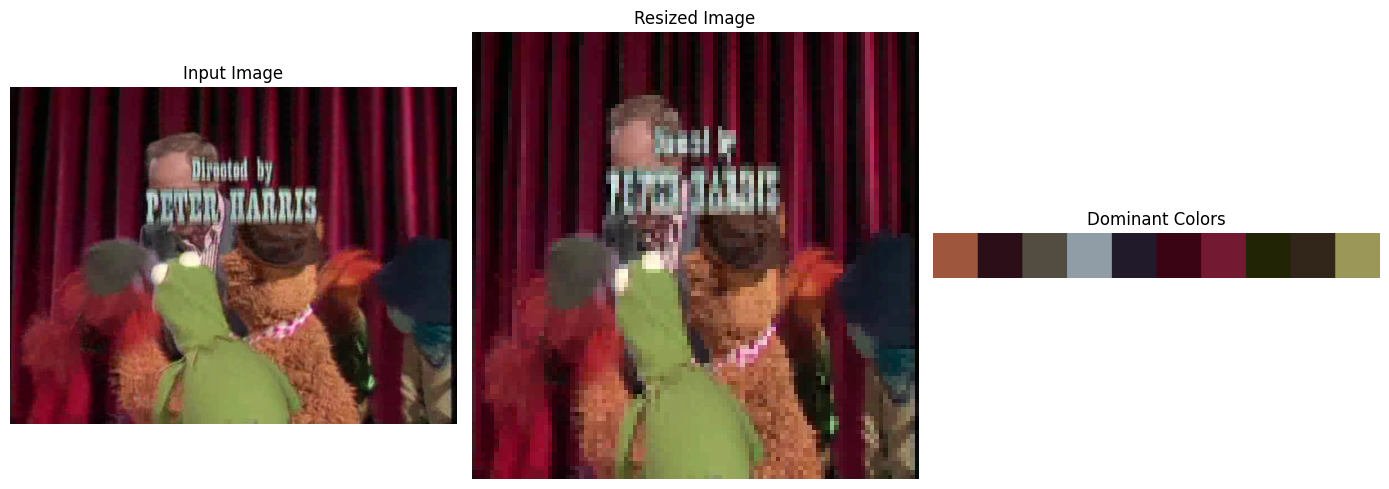

In [32]:
# extract dominant colors
test_dominant_colors = extract_dominant_colors(frame_path, 10, 10)
dominant_colors_bgr = cv2.cvtColor(np.uint8([test_dominant_colors]), cv2.COLOR_HSV2BGR)[0]

# Resize the input image to (100, 100)
resized_img = cv2.resize(test_img, (100, 100))

plt.figure(figsize=(14, 8))

# input  image
plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB))
plt.title("Input Image")
plt.axis("off")

# resized Image
plt.subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB))
plt.title("Resized Image")
plt.axis("off")

# dominant Colors
plt.subplot(1, 3, 3)
color_bar = np.zeros((50, len(dominant_colors_bgr) * 50, 3), dtype=np.uint8)
for i, color in enumerate(dominant_colors_bgr):
    color_bar[:, i * 50:(i + 1) * 50] = color

plt.imshow(cv2.cvtColor(color_bar, cv2.COLOR_BGR2RGB))
plt.title("Dominant Colors")
plt.axis("off")

plt.tight_layout()
plt.show()

<img src="pictures/statler_waldorf_colors.png" alt="SWcolors"/>

Code below allows to see the process dynamically in the video. 
Set `show_video = True` to run the code cell below for the visualisation. 
Note: the variable `n_clusters` must be changed within the loop for experiments, `n_colors` is not needed, it shows all colors by default (10 clusters = 10 colors).  

The code is slightly adapted from the top answer by u1234x1234 in this StackOverflow post https://stackoverflow.com/questions/73808864/get-most-dominant-colors-from-video-opencv-python. 

In [33]:
# Show video with color extraction
show_video = False

if show_video:
    cap = cv2.VideoCapture(vid_path)
    n_clusters = 10

    while True:
        status, image = cap.read()
        if not status:
            break

        # Convert the frame to HSV
        hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

        # Resize the image for clustering and reshape it to a 2D array
        data = cv2.resize(hsv_image, (100, 100)).reshape(-1, 3)

        # Define criteria for k-means clustering
        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1)

        # Apply k-means clustering in HSV
        compactness, labels, centers = cv2.kmeans(
            data.astype(np.float32), 
            n_clusters, 
            None, 
            criteria, 
            10, 
            cv2.KMEANS_PP_CENTERS
        )

        # Convert cluster centers back to RGB
        centers_rgb = cv2.cvtColor(
            centers.reshape(1, -1, 3).astype(np.uint8), 
            cv2.COLOR_HSV2BGR
        ).reshape(-1, 3)

        # Get cluster sizes
        cluster_sizes = np.bincount(labels.flatten())

        # Create a palette to display the dominant colors
        palette = []
        for cluster_idx in np.argsort(-cluster_sizes):
            color_rgb = centers_rgb[cluster_idx]  # Get the RGB color for the cluster
            palette.append(
                np.full(
                    (image.shape[0], image.shape[1], 3), 
                    fill_value=color_rgb, 
                    dtype=np.uint8
                )
            )
        palette = np.hstack(palette)

        # Scale the palette for display
        sf = image.shape[1] / palette.shape[1]
        out = np.vstack([image, cv2.resize(palette, (0, 0), fx=sf, fy=sf)])

        # Display the output
        cv2.imshow("Dominant Colors (RGB)", out)
        if cv2.waitKey(1) & 0xFF == ord('q'):  # Press 'q' to quit
            break

    cap.release()
    cv2.destroyAllWindows()
else:
    print("Set show_video to True to play the video presentation")


Set show_video to True to play the video presentation


## Edge detection (contours)
Next method we are trying for feature engineering is edge detection to describe the shapes within the objects and hopefully effectively separete the subjects of the frame from the background. We only focus on contours for splicity, as we tried algorithms for detecting entire regions as well but did not succeed (see Archive for masking example as one of the methods).

For edge detection, we are using `Canny` method from OpenCV with some preprocessing steps. The figure below summarizes part of our exploration process, excluding the parameter tuning, which we also did. 
We preprocess the frame by applying greyscale and bilateral blur. gaussian blur and median blur. We also resize the images to make it computationally feasible. Judging from the images, the shape is still somewhat recognizable in the 100x100 image, though of course not ideal .
We found bilateral filtering to give us the cleanest edges out of all methods we tried.

In [34]:
# Resize the image for comparison
resized_img = cv2.resize(test_img, (100, 100))

# Convert images to grayscale
gray_original = cv2.cvtColor(test_img, cv2.COLOR_BGR2GRAY)
gray_resized = cv2.resize(gray_original, (100, 100))

# Apply Gaussian blur
gaussian_blur_original = cv2.GaussianBlur(gray_original, (7, 7), 0)
gaussian_blur_resized = cv2.GaussianBlur(gray_resized, (7, 7), 0)

# Apply Bilateral filter
bilateral_blur_original = cv2.bilateralFilter(gray_original, 7, 75, 75)
bilateral_blur_resized = cv2.bilateralFilter(gray_resized, 7, 75, 75)

# Apply Median blur
median_blur_original = cv2.medianBlur(gray_original, 7)
median_blur_resized = cv2.medianBlur(gray_resized, 7)

# Apply edge detection on blurred images
edges_gaussian_original = cv2.Canny(gaussian_blur_original, 75, 75)
edges_gaussian_resized = cv2.Canny(gaussian_blur_resized, 75, 75)

edges_bilateral_original = cv2.Canny(bilateral_blur_original, 75, 75)
edges_bilateral_resized = cv2.Canny(bilateral_blur_resized, 75, 75)

edges_median_original = cv2.Canny(median_blur_original, 75, 75)
edges_median_resized = cv2.Canny(median_blur_resized, 75, 75)

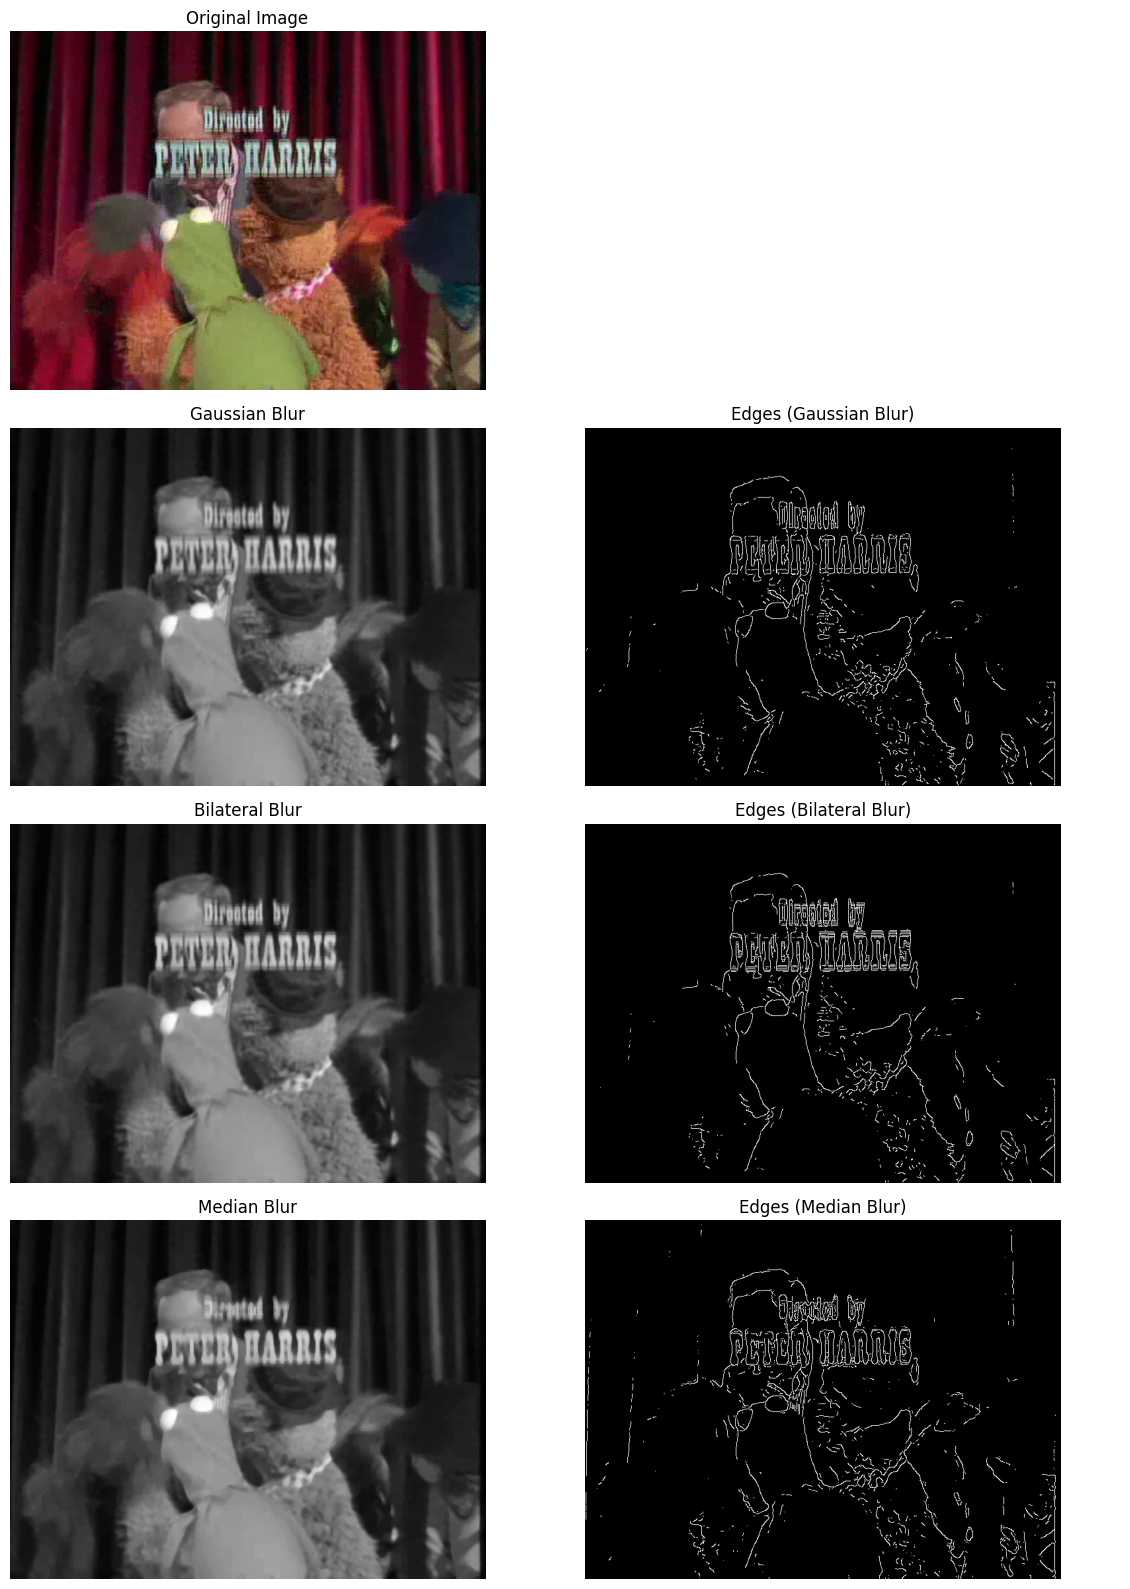

In [35]:
plt.figure(figsize=(12, 16))

# Row 1: Original Image / Blank
plt.subplot(4, 2, 1)
plt.imshow(cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis("off")

plt.subplot(4, 2, 2)
plt.axis("off")  # Leave blank

# Row 2: Gaussian Blur / Gaussian Edges
plt.subplot(4, 2, 3)
plt.imshow(gaussian_blur_original, cmap="gray")
plt.title("Gaussian Blur")
plt.axis("off")

plt.subplot(4, 2, 4)
plt.imshow(edges_gaussian_original, cmap="gray")
plt.title("Edges (Gaussian Blur)")
plt.axis("off")

# Row 3: Bilateral Blur / Bilateral Edges
plt.subplot(4, 2, 5)
plt.imshow(bilateral_blur_original, cmap="gray")
plt.title("Bilateral Blur")
plt.axis("off")

plt.subplot(4, 2, 6)
plt.imshow(edges_bilateral_original, cmap="gray")
plt.title("Edges (Bilateral Blur)")
plt.axis("off")

# Row 4: Median Blur / Median Edges
plt.subplot(4, 2, 7)
plt.imshow(median_blur_original, cmap="gray")
plt.title("Median Blur")
plt.axis("off")

plt.subplot(4, 2, 8)
plt.imshow(edges_median_original, cmap="gray")
plt.title("Edges (Median Blur)")
plt.axis("off")

plt.tight_layout()
plt.show()

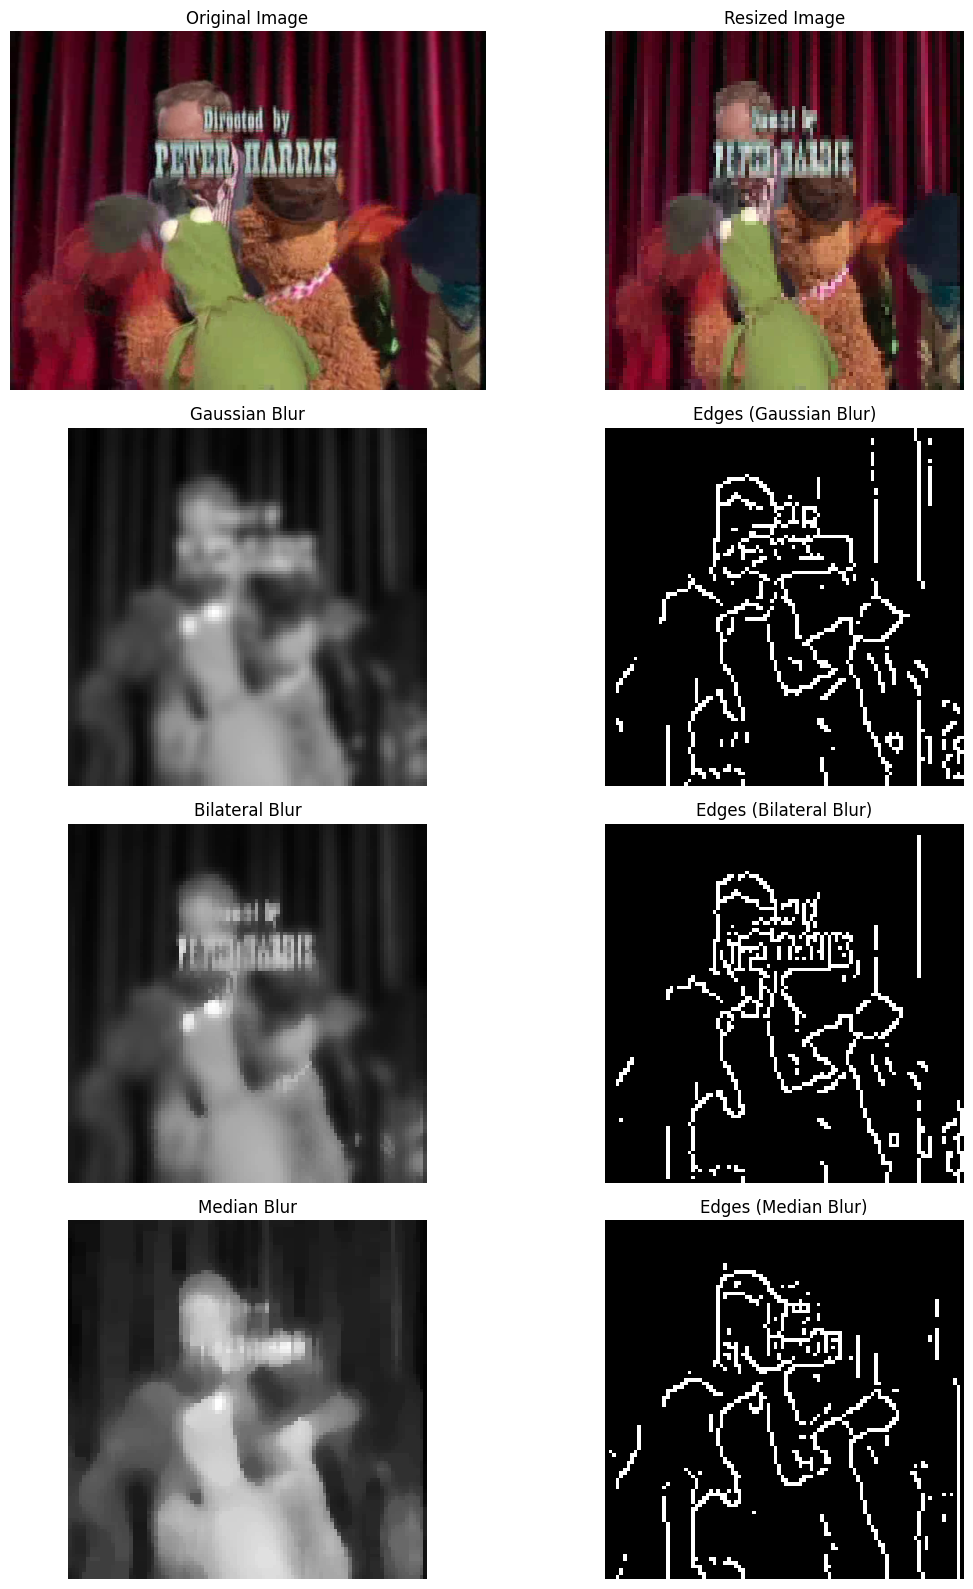

In [36]:
# Resize the image for comparison
resized_img = cv2.resize(test_img, (100, 100))

# Convert images to grayscale
gray_original = cv2.cvtColor(test_img, cv2.COLOR_BGR2GRAY)
gray_resized = cv2.resize(gray_original, (100, 100))

# Apply Gaussian blur
gaussian_blur_original = cv2.GaussianBlur(gray_original, (7, 7), 0)
gaussian_blur_resized = cv2.GaussianBlur(gray_resized, (7, 7), 0)

# Apply Bilateral filter
bilateral_blur_original = cv2.bilateralFilter(gray_original, 7, 75, 75)
bilateral_blur_resized = cv2.bilateralFilter(gray_resized, 7, 75, 75)

# Apply Median blur
median_blur_original = cv2.medianBlur(gray_original, 7)
median_blur_resized = cv2.medianBlur(gray_resized, 7)

# Apply edge detection on blurred images
edges_gaussian_original = cv2.Canny(gaussian_blur_original, 75, 75)
edges_gaussian_resized = cv2.Canny(gaussian_blur_resized, 75, 75)

edges_bilateral_original = cv2.Canny(bilateral_blur_original, 75, 75)
edges_bilateral_resized = cv2.Canny(bilateral_blur_resized, 75, 75)

edges_median_original = cv2.Canny(median_blur_original, 75, 75)
edges_median_resized = cv2.Canny(median_blur_resized, 75, 75)

plt.figure(figsize=(12, 16))

# Row 1: Original Image / Resized Image
plt.subplot(4, 2, 1)
plt.imshow(cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis("off")

plt.subplot(4, 2, 2)
plt.imshow(cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB))
plt.title("Resized Image")
plt.axis("off")

# Row 2: Gaussian Blur / Gaussian Edges
plt.subplot(4, 2, 3)
plt.imshow(gaussian_blur_resized, cmap="gray")
plt.title("Gaussian Blur")
plt.axis("off")

plt.subplot(4, 2, 4)
plt.imshow(edges_gaussian_resized, cmap="gray")
plt.title("Edges (Gaussian Blur)")
plt.axis("off")

# Row 3: Bilateral Blur / Bilateral Edges
plt.subplot(4, 2, 5)
plt.imshow(bilateral_blur_resized, cmap="gray")
plt.title("Bilateral Blur")
plt.axis("off")

plt.subplot(4, 2, 6)
plt.imshow(edges_bilateral_resized, cmap="gray")
plt.title("Edges (Bilateral Blur)")
plt.axis("off")

# Row 4: Median Blur / Median Edges
plt.subplot(4, 2, 7)
plt.imshow(median_blur_resized, cmap="gray")
plt.title("Median Blur")
plt.axis("off")

plt.subplot(4, 2, 8)
plt.imshow(edges_median_resized, cmap="gray")
plt.title("Edges (Median Blur)")
plt.axis("off")

plt.tight_layout()
plt.show()


To save some space, we provide pictures how the same process works for two older gentlemen. The same functions as above were used to produce the images. 

<img src="pictures/statler_waldorf_original_contours.png" alt="SWcontorsoriginal" width="1000"/>

<img src="pictures/statler_waldorf_resized_contrours.png" alt="SWcontorsresized" width="1000"/>

In [37]:
show_video = False

def extract_contours_video(image, d=7):
    """
    update function for the video
    """
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    bilateral_blur = cv2.bilateralFilter(gray, d, 75, 75)
    edges = cv2.Canny(bilateral_blur, 75, 150)
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    return contours

if show_video:
    cap = cv2.VideoCapture(vid_path)
    
    while True:
        status, image = cap.read()
        if not status:
            break

        # extract contours from the current frame
        contours = extract_contours_video(image)

        # draw contours on the original frame
        output_image = image.copy()
        cv2.drawContours(output_image, contours, -1, (0, 255, 0), 2)

        # display the frame with contours
        cv2.imshow("Contours", output_image)

        # press 'q' to exit the video loop
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()
else:
    print("Set show_video to True to play the video presentation")

Set show_video to True to play the video presentation


## Texture (GLCM) 
Gray-Level Co-occurrence Matrix (GLCM) captures how pairs of neighboring pixels with specific values co-occur in an image, considering a particular distance and angle. These pixel pairs are used to capture the spatial patterns in the image, which can be indicative of the texture. Using `skimage` library we can conveniently extract the following features: contrast, correlation, energy and homogeneity. These features help with image segmentation and especially texture detection. Images must be grayscale for this method. 

GLCM Features:
Contrast: 0.6662420895389538
Correlation: 0.3337906412229046
Energy: 0.3029952995067809
Homogeneity: 0.3031977640543901


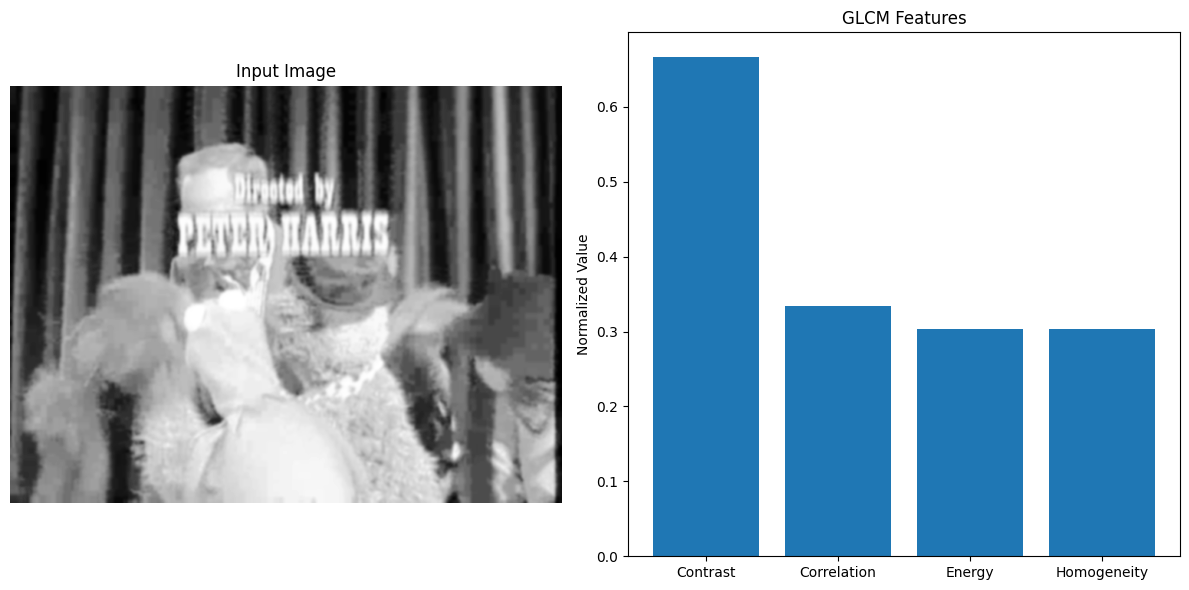

In [38]:
image_gray = cv2.imread(frame_path, cv2.IMREAD_GRAYSCALE)

# Preprocess the image 
image_gray = cv2.equalizeHist(image_gray) 
image_gray = cv2.GaussianBlur(image_gray, (7, 7), 0)  

# Extract GLCM features using the custom function
glcm_features = extract_glcm_features(frame_path, distance=1) 

print("GLCM Features:")
print(f"Contrast: {glcm_features['Contrast']}")
print(f"Correlation: {glcm_features['Correlation']}")
print(f"Energy: {glcm_features['Energy']}")
print(f"Homogeneity: {glcm_features['Homogeneity']}")

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(image_gray, cmap='gray')
axes[0].set_title("Input Image")
axes[0].axis("off")

axes[1].bar(['Contrast', 'Correlation', 'Energy', 'Homogeneity'],
            [np.mean(glcm_features['Contrast']),
             np.mean(glcm_features['Correlation']),
             np.mean(glcm_features['Energy']),
             np.mean(glcm_features['Homogeneity'])])
axes[1].set_title("GLCM Features")
axes[1].set_ylabel("Normalized Value")

plt.tight_layout()
plt.show()

<img src="pictures/statler_waldorf_glcm.png" alt="SWglcm"/>

## Extract features

Now that we are done with our analysis and feature extraction function definition, we can apply the functions on our data. It takes a while to extract the features, so only run the following cells if necessary. The outputs of the cells are saved as `.csv` files in a specified directories. One of the files (edges) is really big and will be ove 3GB, so proceed with caution.

In [39]:
extract = False

if extract==True:
    dominant_colors_features = extract_dominant_colors_from_video(frames, num_clusters=10, num_colors=10)
    df_color_features = pd.DataFrame(dominant_colors_features)
    df_color_features.to_csv('../model_data/features/dominant_colors_features.csv', index=False)
else: 
    print("Set extract to True to extract color features")

Set extract to True to extract color features


In [40]:
extract = False
# warning: large file! 

if extract==True:
    contours_features = extract_contours_from_video(frames, d=7)
    df_contours_features = pd.DataFrame(contours_features)
    df_contours_features.to_csv('../model_data/features/contours_features.csv', index=False)
else: 
    print("Set extract to True to extract contours")

Set extract to True to extract contours


In [41]:
extract = False

if extract==True:
    glcm_features = extract_glcm_features_from_video(frames)
    df_glcm_features = pd.DataFrame(glcm_features)
    df_glcm_features.to_csv('../model_data/features/glcm_features.csv', index=False)
else: 
    print("Set extract to True to extract GLCM features")

Set extract to True to extract GLCM features


We can access the feature files now and write them into dataframes.

In [42]:
try:
    df_glcm_features = pd.read_csv("../model_data/features/glcm_features.csv")
    df_contours_features = pd.read_csv("../model_data/features/contours_features.csv")
    df_color_features = pd.read_csv("../model_data/features/dominant_colors_features.csv")
except: 
    print("Make sure you have the feature files and the paths are correct")

Now we have our features but we cannot use them directly to train the model yet. Even though we reduced the dimensions of frames to extract edges, the file containing them still weighs 3.6 GB and contains too many dimensions for us to handle. We cannot process this amount of data, let alone train a reasonable model with cross-validation approach without drastically reducing the dimensions of our features. We attempt PCA here as additional preprocessing step. 

In [43]:
contours_npy = np.load('../model_data/features/contours.npy')
contours_npy = contours_npy / 255.0  #convert to 0 and 1

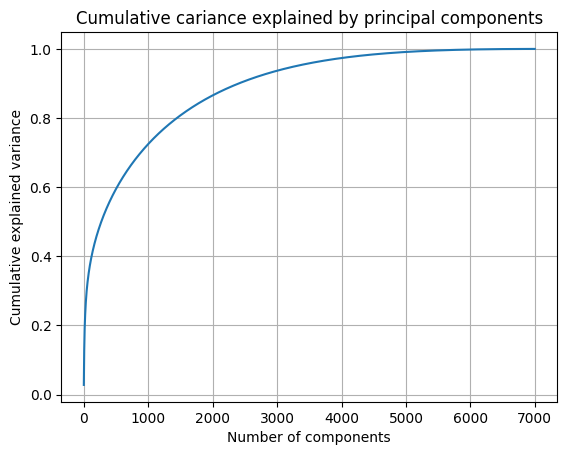

In [ ]:
pca = PCA()
pca.fit(contours_npy[380:7380]) #first 7000 frames without intro
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

plt.plot(cumulative_variance)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.title('Cumulative cariance explained by principal components')
plt.grid(True)
plt.show()

We calculated the cumulative explained variance for different number of principal components and obtained the plot above. Since the calculation also takes a while, we only considered first 7000 frames excluding black intro frames. We also tried SparsePCA and NMF but they were not computationally feasible. 
The plot above shows the cumulative explained variance depending on the number of components. Assuming that 7000 frames are represenative of our dataset as whole, 1000 components will explain above 70% of variance, and around 500 components would suffice for 60%. While our ideal target would be around 90-95%, we cannot afford it. We will keep 500 components and combine these features with other to hopefully get good results.

In [45]:
pca = PCA(n_components=500)  
contours_pca = pca.fit_transform(contours_npy)
contours_df = pd.DataFrame(contours_pca, columns=[f'PC{i+1}' for i in range(500)])
contours_df['video_id'] = df_contours_features['video_id']
contours_df['frame_id'] = df_contours_features['frame_id']

In [46]:
dominant_colors_df = df_color_features.copy("deep")
dominant_colors_df['dominant_colors'] = dominant_colors_df['dominant_colors'].apply(ast.literal_eval)                                                     
dominant_colors_df = pd.DataFrame(dominant_colors_df['dominant_colors'].to_list(),columns=[f'color{i+1}' for i in range(10)])

for i in dominant_colors_df.columns.tolist():
    dominant_colors_df = pd.concat([dominant_colors_df, pd.DataFrame(dominant_colors_df[i].to_list(),columns=[f'{i}{j+1}' for j in range(3)])], axis=1)
    
dominant_colors_df = dominant_colors_df.drop([f'color{i+1}' for i in range(10)], axis=1)
dominant_colors_df['video_id'] = df_color_features['video_id']
dominant_colors_df['frame_id'] = df_color_features['frame_id']

In [47]:
glcm_features_df = df_glcm_features.copy("deep")
glcm_features_df['video_id'] = df_glcm_features['video_id']
glcm_features_df['frame_id'] = df_glcm_features['frame_id']

## Prepare model data

In [48]:
annotations_combined = pd.concat([annotations['Muppets-02-01-01.avi'],
                                  annotations['Muppets-02-04-04.avi'],
                                  annotations['Muppets-03-04-03.avi']],
                                  axis=0, ignore_index=True)

annotations_combined["Video"] = annotations_combined["Video"].replace({211:0, 244:1, 343:2}) 
annotations_combined = annotations_combined.rename(columns = {"Video":"video_id", "Frame_number":"frame_id"})

In [49]:
model_data = pd.merge(annotations_combined[["video_id", "frame_id", "Kermit", "StatlerWaldorf"]], contours_df, how="left", on=["video_id", "frame_id"])
model_data = pd.merge(model_data, dominant_colors_df, how="left", on=["video_id", "frame_id"])
model_data = pd.merge(model_data, glcm_features_df, how="left", on=["video_id", "frame_id"])

In [50]:
model_data = model_data.rename(columns = {"video_id":"video_idx", "frame_id":"frame_idx"})
data, split_overview = partition_feature_df(model_data, grp_by = ["Kermit", "StatlerWaldorf"])

In [51]:
split_overview

,video_idx,fold,Kermit,StatlerWaldorf
0,0,0-A,2916,1336
1,0,0-B,2533,463
2,1,1-A,3925,665
3,1,1-B,8327,393
4,2,2-A,5231,322
5,2,2-B,10277,531


In [52]:
data_train = data.loc[~data["fold"].isin(["1-A", "0-B"])]
data_test = data.loc[data["fold"].isin(["1-A", "0-B"])]

In [53]:
print(data_train.shape)
print(data_test.shape)

(77201, 539)
(38684, 539)


# Kermit Classification

In [54]:
X_train_kermit = data_train.drop(["video_idx", "frame_idx", "fold", "Kermit", "StatlerWaldorf"], axis=1)
y_train_kermit = data_train["Kermit"]
X_test_kermit = data_test.drop(["video_idx", "frame_idx", "fold", "Kermit", "StatlerWaldorf"], axis=1)
y_test_kermit = data_test["Kermit"]

## KNN

In [101]:
scaler = StandardScaler()

np.random.seed(42)

X_train_kermit_scaled = scaler.fit_transform(X_train_kermit)
X_test_kermit_scaled = scaler.transform(X_test_kermit)

knn = KNeighborsClassifier(weights="distance", metric="euclidean", n_neighbors=3)
knn.fit(X_train_kermit_scaled, y_train_kermit)
y_pred_kermit_knn = knn.predict(X_test_kermit_scaled)

metrics_kermit_knn = {
    'accuracy': accuracy_score(y_test_kermit, y_pred_kermit_knn),
    'precision': precision_score(y_test_kermit, y_pred_kermit_knn, average='binary', zero_division=0),
    'recall': recall_score(y_test_kermit, y_pred_kermit_knn, average='binary', zero_division=0),
    'f1': f1_score(y_test_kermit, y_pred_kermit_knn, average='binary', zero_division=0)
}

pd.DataFrame(y_pred_kermit_knn).to_csv("../model_data/results/y_pred_kermit_knn.csv")

print("Evaluation Metrics:")
for metric, value in metrics_kermit_knn.items():
    print(f"{metric}: {value:.4f}")

Evaluation Metrics:
accuracy: 0.8378
precision: 0.7563
recall: 0.0418
f1: 0.0792


Evaluation Metrics for Kermit KNN Model:
Accuracy: 0.8378
Precision: 0.8248
Recall: 0.8378
F1 Score: 0.7722


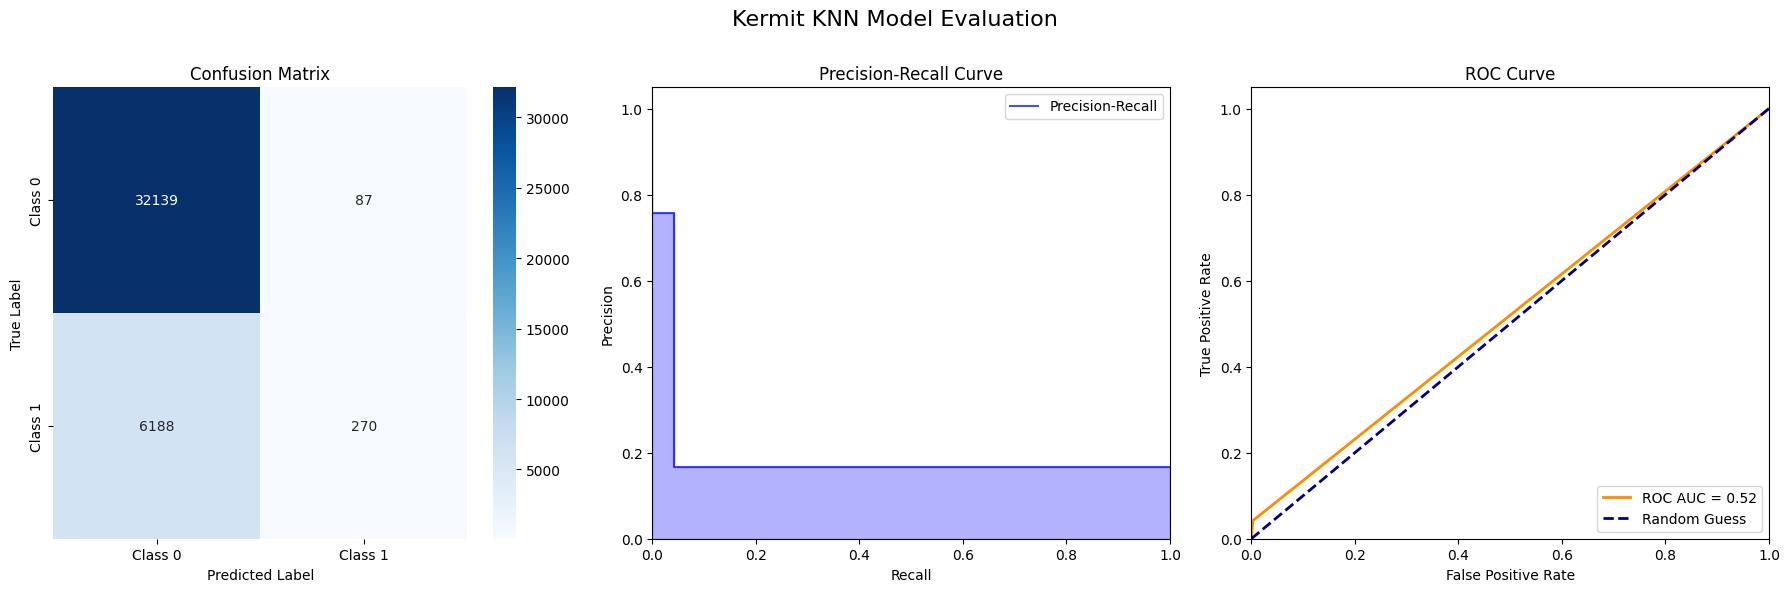

In [84]:
evaluate_model(y_test_kermit, y_pred_kermit_knn, title="Kermit KNN Model")

## Decision Tree

In [ ]:
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train_kermit, y_train_kermit)
y_pred_kermit_dt = dt.predict(X_test_kermit)

metrics_kermit_dt = {
    'accuracy': accuracy_score(y_test_kermit, y_pred_kermit_dt),
    'precision': precision_score(y_test_kermit, y_pred_kermit_dt, average='binary', zero_division=0),
    'recall': recall_score(y_test_kermit, y_pred_kermit_dt, average='binary', zero_division=0),
    'f1': f1_score(y_test_kermit, y_pred_kermit_dt, average='binary', zero_division=0)
}

pd.DataFrame(y_pred_kermit_dt).to_csv("../model_data/results/y_pred_kermit_dt.csv")

print("Evaluation Metrics:")
for metric, value in metrics_kermit_dt.items():
    print(f"{metric}: {value:.4f}")

Evaluation Metrics:
accuracy: 0.6632
precision: 0.2419
recall: 0.4769
f1: 0.3210


Evaluation Metrics for Kermit Decision Tree:
Accuracy: 0.6632
Precision: 0.7650
Recall: 0.6632
F1 Score: 0.7001


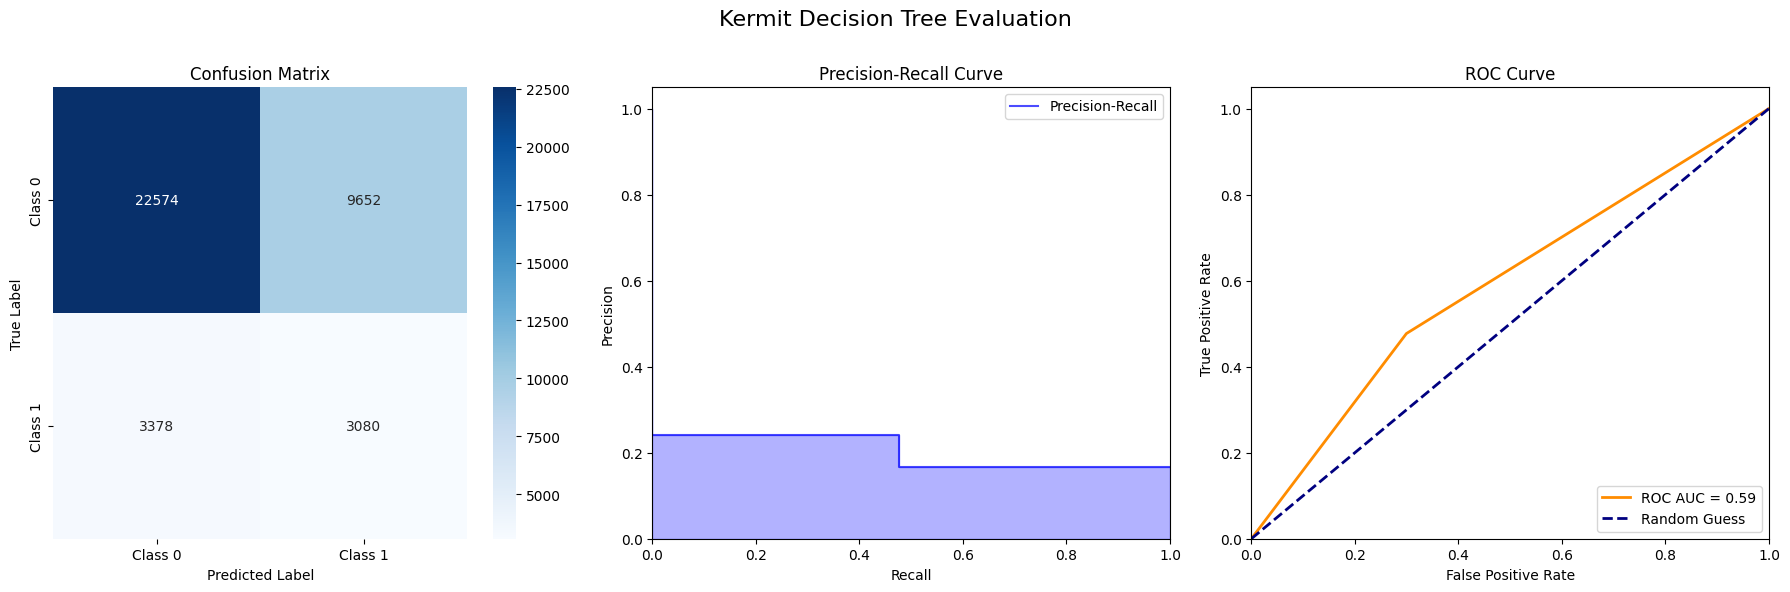

In [85]:
evaluate_model(y_test_kermit, y_pred_kermit_dt, title="Kermit Decision Tree")

## Logistic Regression

In [99]:
lr = LogisticRegression(penalty='l1', solver="saga", max_iter=1000, random_state=42)
lr.fit(X_train_kermit, y_train_kermit)
y_pred_kermit_lr = lr.predict(X_test_kermit)

metrics_kermit_lr = {
    'accuracy': accuracy_score(y_test_kermit, y_pred_kermit_lr),
    'precision': precision_score(y_test_kermit, y_pred_kermit_lr, average='binary', zero_division=0),
    'recall': recall_score(y_test_kermit, y_pred_kermit_lr, average='binary', zero_division=0),
    'f1': f1_score(y_test_kermit, y_pred_kermit_lr, average='binary', zero_division=0)
}

pd.DataFrame(y_pred_kermit_lr).to_csv("../model_data/results/y_pred_kermit_lr.csv")

print("Evaluation Metrics:")
for metric, value in metrics_kermit_lr.items():
    print(f"{metric}: {value:.4f}")

Evaluation Metrics:
accuracy: 0.7419
precision: 0.3207
recall: 0.4882
f1: 0.3871


Evaluation Metrics for Kermit Logistic Regression:
Accuracy: 0.7419
Precision: 0.7912
Recall: 0.7419
F1 Score: 0.7615


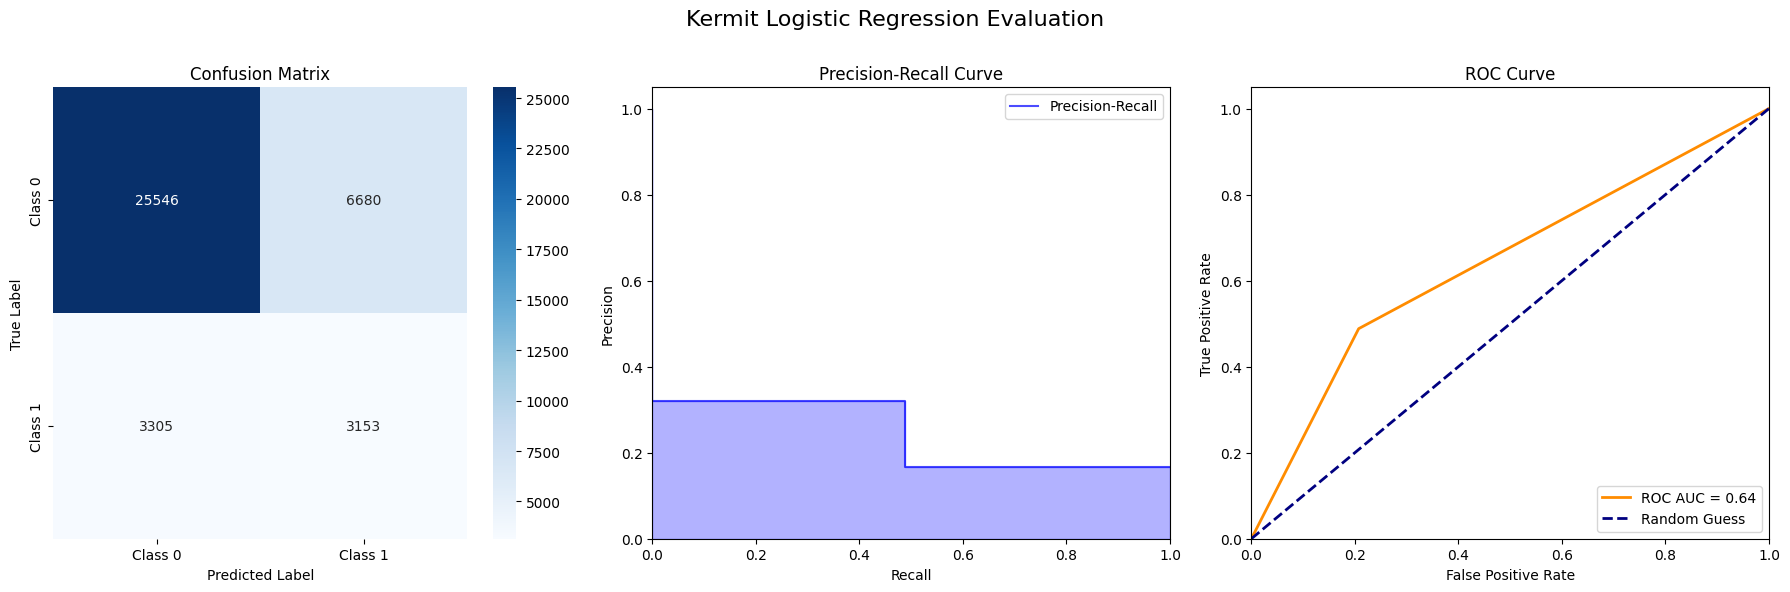

In [86]:
evaluate_model(y_test_kermit, y_pred_kermit_lr, title="Kermit Logistic Regression")

# Waldorf&Statler Classification

In [58]:
X_train_sw = data_train.drop(["video_idx", "frame_idx", "fold", "Kermit", "StatlerWaldorf"], axis=1)
y_train_sw = data_train["StatlerWaldorf"]
X_test_sw = data_test.drop(["video_idx", "frame_idx", "fold", "Kermit", "StatlerWaldorf"], axis=1)
y_test_sw = data_test["StatlerWaldorf"]

## KNN

In [98]:
scaler = StandardScaler()

X_train_sw_scaled = scaler.fit_transform(X_train_sw)
X_test_sw_scaled = scaler.transform(X_test_sw)

knn = KNeighborsClassifier(weights="distance", metric="euclidean", n_neighbors=3)
knn.fit(X_train_sw_scaled, y_train_sw)
y_pred_sw_knn = knn.predict(X_test_sw_scaled)

metrics_sw_knn = {
    'accuracy': accuracy_score(y_test_sw, y_pred_sw_knn),
    'precision': precision_score(y_test_sw, y_pred_sw_knn, average='binary', zero_division=0),
    'recall': recall_score(y_test_sw, y_pred_sw_knn, average='binary', zero_division=0),
    'f1': f1_score(y_test_sw, y_pred_sw_knn, average='binary', zero_division=0)
}

pd.DataFrame(y_pred_sw_knn).to_csv("../model_data/results/y_pred_sw_knn.csv")

print("Evaluation Metrics:")
for metric, value in metrics_sw_knn.items():
    print(f"{metric}: {value:.4f}")

Evaluation Metrics:
accuracy: 0.9721
precision: 0.8429
recall: 0.0523
f1: 0.0985


Evaluation Metrics for StatlerWaldorf KNN:
Accuracy: 0.9721
Precision: 0.9685
Recall: 0.9721
F1 Score: 0.9599


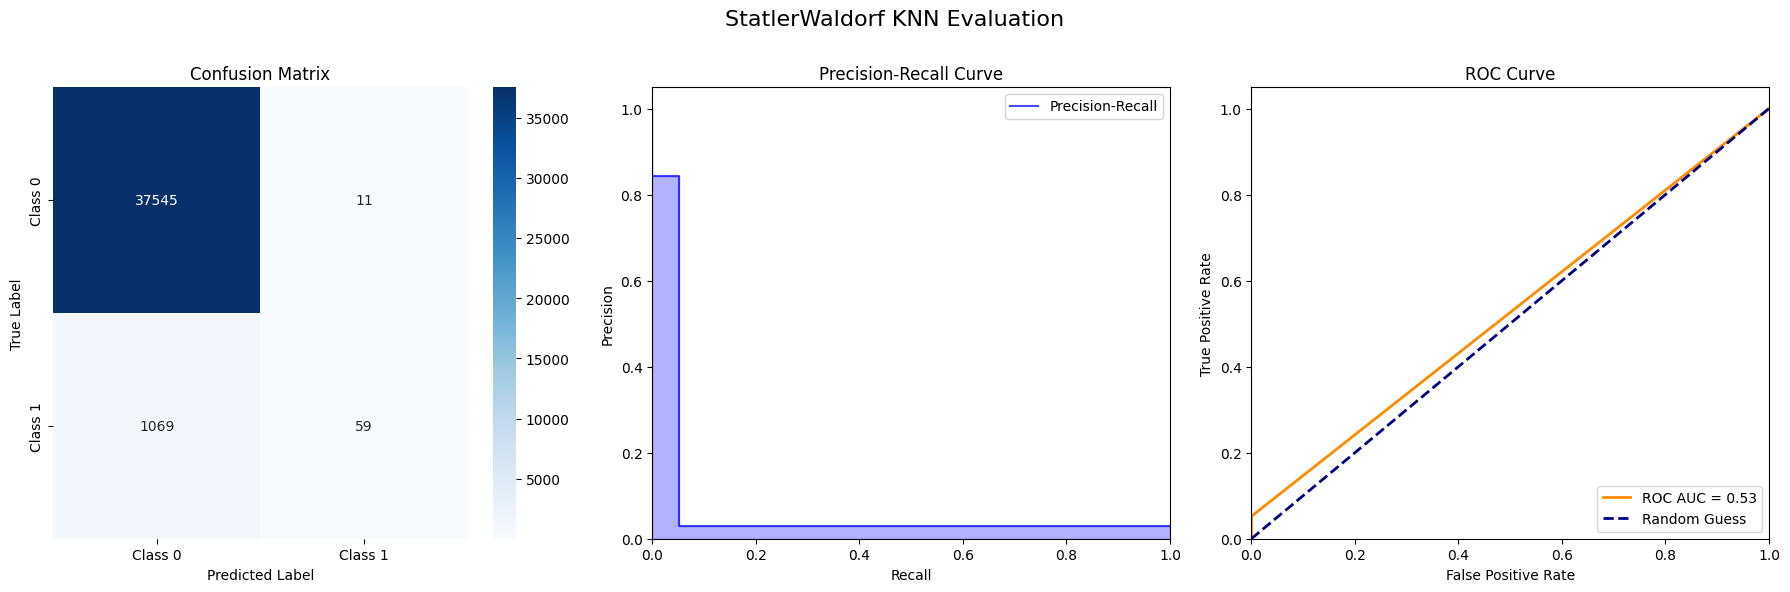

In [87]:
evaluate_model(y_test_sw, y_pred_sw_knn, title="StatlerWaldorf KNN")

## Decision Tree

In [97]:
dt = DecisionTreeClassifier()
dt.fit(X_train_sw, y_train_sw)
y_pred_sw_dt = dt.predict(X_test_sw)

metrics_sw_dt = {
    'accuracy': accuracy_score(y_test_sw, y_pred_sw_dt),
    'precision': precision_score(y_test_sw, y_pred_sw_dt, average="binary", zero_division=0),
    'recall': recall_score(y_test_sw, y_pred_sw_dt, average="binary", zero_division=0),
    'f1': f1_score(y_test_sw, y_pred_sw_dt, average="binary", zero_division=0)
}

pd.DataFrame(y_pred_sw_dt).to_csv("../model_data/results/y_pred_sw_dt.csv")

print("Evaluation Metrics:")
for metric, value in metrics_sw_dt.items():
    print(f"{metric}: {value:.4f}")

Evaluation Metrics:
accuracy: 0.9606
precision: 0.1120
recall: 0.0505
f1: 0.0696


Evaluation Metrics for StatlerWaldorf Decision Tree:
Accuracy: 0.9606
Precision: 0.9469
Recall: 0.9606
F1 Score: 0.9533


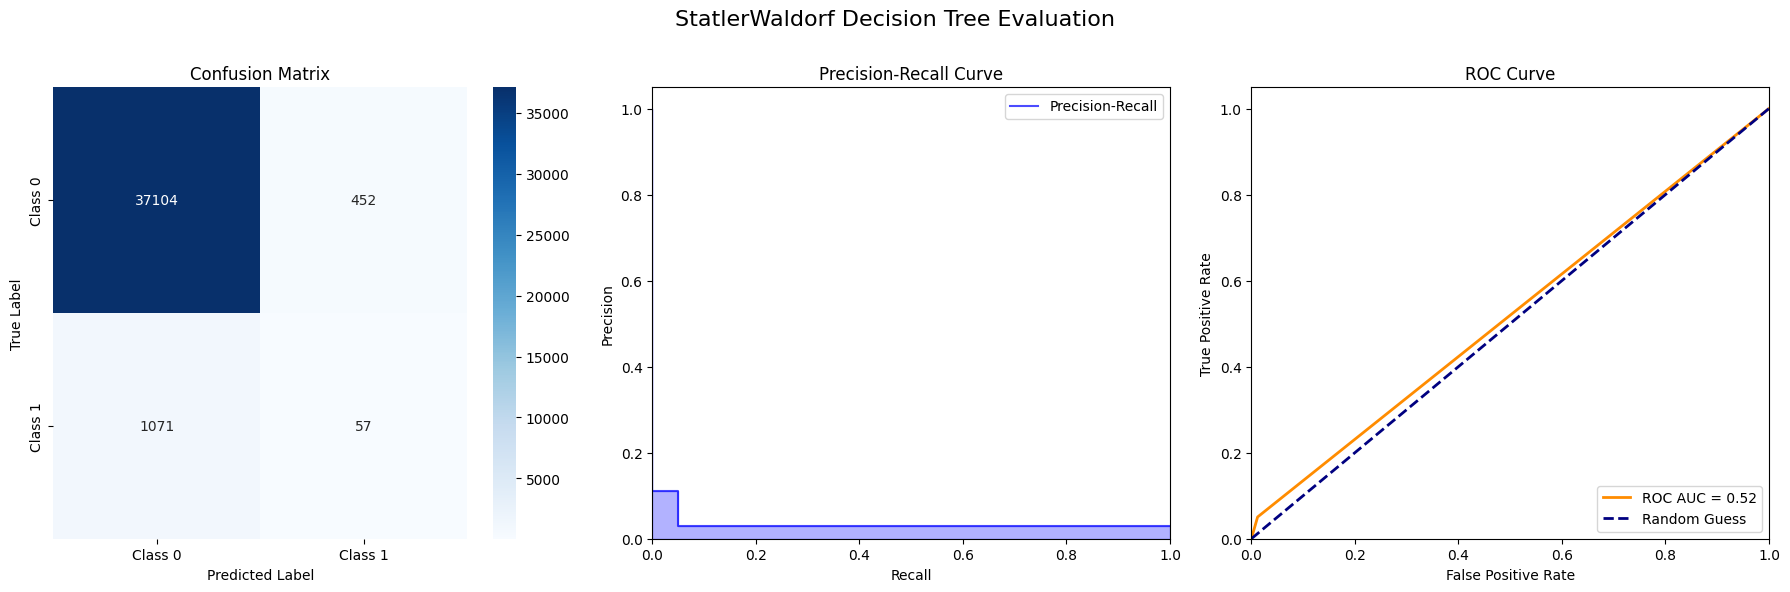

In [89]:
evaluate_model(y_test_sw, y_pred_sw_dt, title="StatlerWaldorf Decision Tree")

## Logistic Regression

In [96]:
lr = LogisticRegression(penalty='l1', solver="saga", max_iter=1000)
lr.fit(X_train_sw, y_train_sw)
y_pred_sw_lr = lr.predict(X_test_sw)

metrics_sw_lr = {
    'accuracy': accuracy_score(y_test_sw, y_pred_sw_lr),
    'precision': precision_score(y_test_sw, y_pred_sw_lr, average='binary', zero_division=0),
    'recall': recall_score(y_test_sw, y_pred_sw_lr, average='binary', zero_division=0),
    'f1': f1_score(y_test_sw, y_pred_sw_lr, average='binary', zero_division=0)
}

pd.DataFrame(y_pred_sw_lr).to_csv("../model_data/results/y_pred_sw_lr.csv")

print("Evaluation Metrics:")
for metric, value in metrics_sw_lr.items():
    print(f"{metric}: {value:.4f}")

Evaluation Metrics:
accuracy: 0.9931
precision: 0.9664
recall: 0.7899
f1: 0.8693


Evaluation Metrics for StatlerWaldorf Logistic Regression:
Accuracy: 0.9931
Precision: 0.9929
Recall: 0.9931
F1 Score: 0.9927


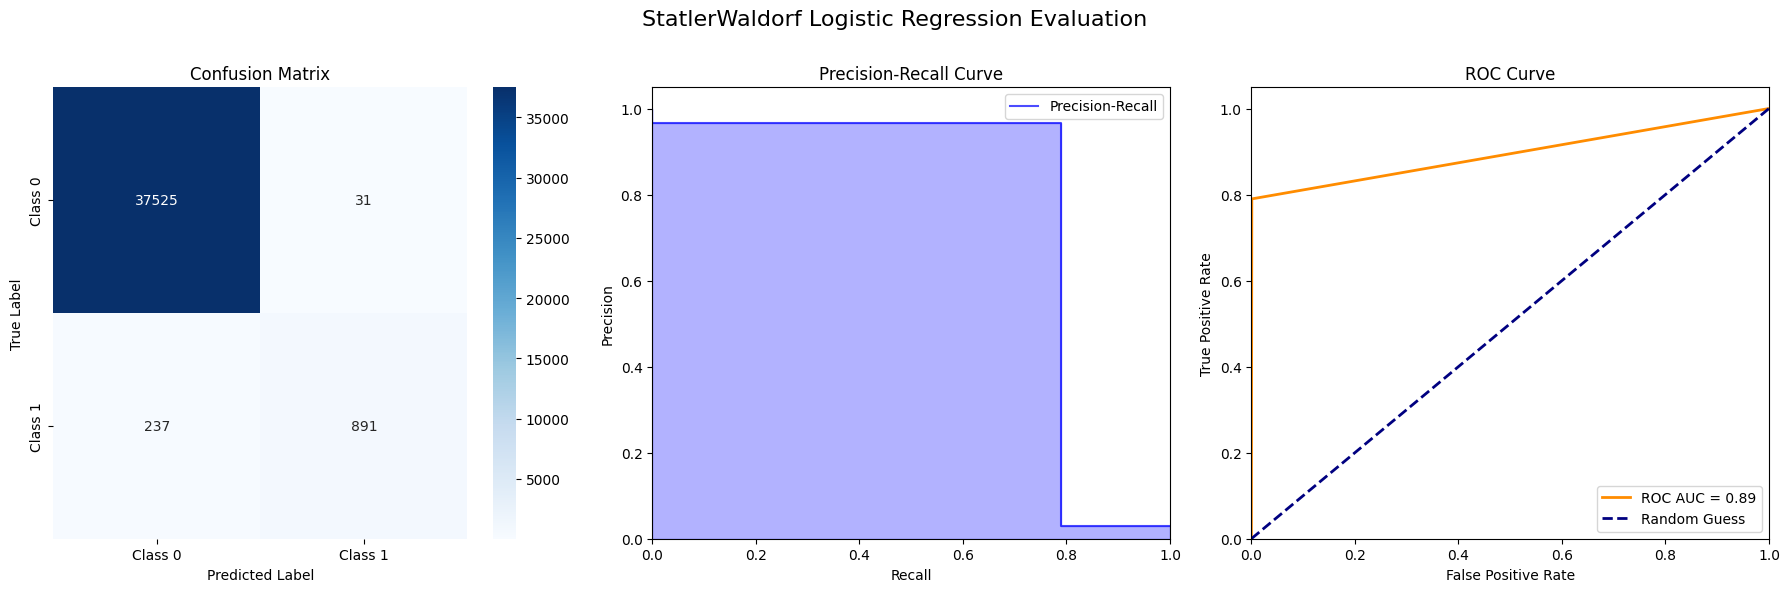

In [95]:
evaluate_model(y_test_sw, y_pred_sw_lr, title="StatlerWaldorf Logistic Regression")

# Conclusion
Logistic Regression performed best for both Kermit and Statler&Waldorf. Kermit classification task based on visual features turned out to be rather difficult, as we were unable to achieve good performance with any of the approaches. There is a significant class imbalance that influences the training and testing outcomes, as well as some instances of mislabeling in the annotations that impact the performance.

# Archive
One of the method we experimented with involved masking the characters to separate them from background. We considered using this method as a preprocessing step but did not find a good way to make it automatic and efficient. Below is an example with manually defined color ranges for Kermit applied to a frame with and without Kermit. We can see that we masked Kermit pretty well, and identified more connected components of the define shades, so that could be a potential feature. However, this method as-is would require us to thoroughly analyse the targets we are looking for and their colors, apply combined masks, and overall make the solution too tailored to call it feature extrction because we will land in the realm of direct pattern matching, which is already a classification step.

Number of connected components (with Kermit): 489
Number of connected components (without Kermit): 332


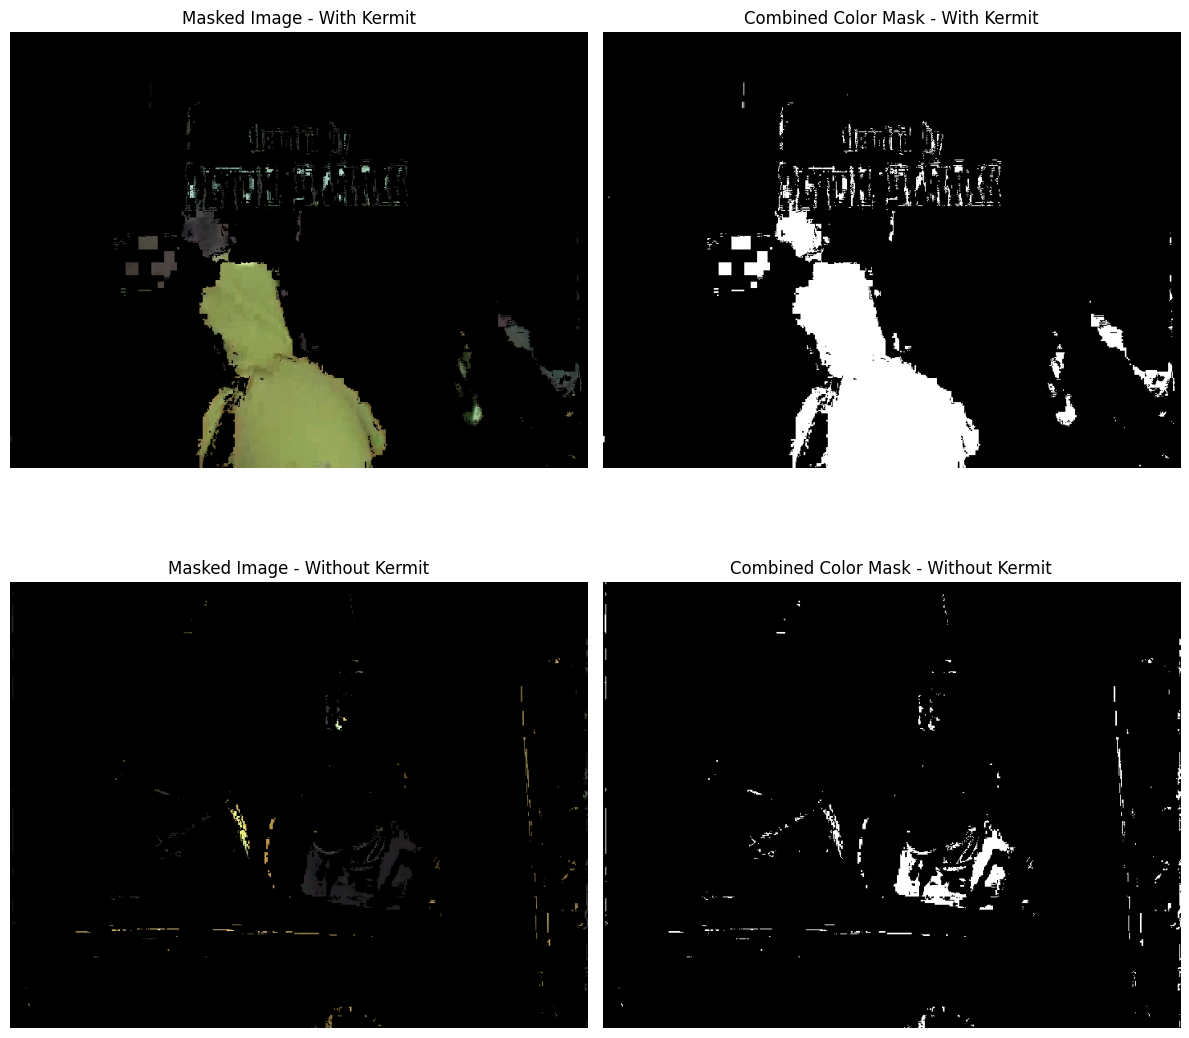

In [62]:
# function to apply mask and get masked image
def get_masked_image(image):
    # Convert the image to HSV
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # define multiple color ranges for Kermit (including variations of green, yellow, and dark shades)
    color_ranges = [
        (np.array([35, 40, 40]), np.array([85, 255, 255])),  # Green (flexible range)
        (np.array([20, 100, 100]), np.array([35, 255, 255])),  # Yellow
        (np.array([0, 0, 30]), np.array([180, 50, 80]))  # Dark shades
    ]

    combined_mask = np.zeros(image_hsv.shape[:2], dtype=np.uint8)
    for lower, upper in color_ranges:
        mask = cv2.inRange(image_hsv, lower, upper)
        combined_mask = cv2.bitwise_or(combined_mask, mask)

    masked_image = cv2.bitwise_and(image, image, mask=combined_mask)

    return masked_image, combined_mask

# function to extract area and shape features (number of connected components)
def extract_area_and_shape_features(mask):
    # find connected components in the mask
    num_components, labels = cv2.connectedComponents(mask)
    
    # the number of connected components is num_components - 1,
    # because the background is also considered as one component (label 0)
    return num_components - 1

test_img_with_kermit = test_img
test_img_without_kermit = test_img2

# get masked images for both frames
masked_img_kermit, mask_kermit = get_masked_image(test_img_with_kermit)
masked_img_nokermit, mask_nokermit = get_masked_image(test_img_without_kermit)

# extract the number of connected components for both masks
num_connected_components_kermit = extract_area_and_shape_features(mask_kermit)
num_connected_components_nokermit = extract_area_and_shape_features(mask_nokermit)

print(f"Number of connected components (with Kermit): {num_connected_components_kermit}")
print(f"Number of connected components (without Kermit): {num_connected_components_nokermit}")

plt.figure(figsize=(12, 12))

# Kermit frame
plt.subplot(2, 2, 1)
plt.imshow(cv2.cvtColor(masked_img_kermit, cv2.COLOR_BGR2RGB))
plt.title("Masked Image - With Kermit")
plt.axis("off")

plt.subplot(2, 2, 2)
plt.imshow(mask_kermit, cmap="gray")
plt.title("Combined Color Mask - With Kermit")
plt.axis("off")

# SW frame
plt.subplot(2, 2, 3)
plt.imshow(cv2.cvtColor(masked_img_nokermit, cv2.COLOR_BGR2RGB))
plt.title("Masked Image - Without Kermit")
plt.axis("off")

plt.subplot(2, 2, 4)
plt.imshow(mask_nokermit, cmap="gray")
plt.title("Combined Color Mask - Without Kermit")
plt.axis("off")

plt.tight_layout()
plt.show()